<a href="https://colab.research.google.com/github/babyraggge/time-data-prediction-methods/blob/main/practice6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение вейвлет сетодов для декомпозирования временных рядов

Бельтюков РИ-481223

In [97]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

import h5py
import pywt

%matplotlib inline

Создадим зашумленный временной ряд с 2 периодиками:

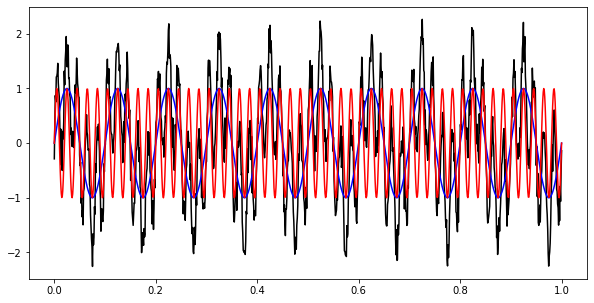

In [98]:
t = np.linspace(0,1,1024)
f1 = 10
f2 = 50
F = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + 0.2*rand.randn(len(t))

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.show()

Для начала используем вейвлет Мейера:

In [99]:
wvlt = pywt.Wavelet('dmey')

Узнаем уровень возможного разложения:

In [100]:
pywt.dwt_max_level(len(F), wvlt) #будет выведено число 4

4

Разобъем исходный ряд на компоненты с  помощью  вейвлета Мейера, в режиме периодизации, до 4 уровня декомпозиции:

In [101]:
cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(F, wvlt, mode='periodization', level=4)

Восстановим две периодики исходного модельного ряда:

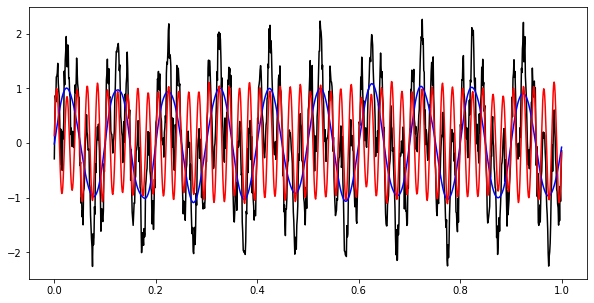

In [102]:
Fre = pywt.waverec((cA4, None, None, None, None), wvlt, mode='periodization')
Fre2 = pywt.waverec((None, cD4, None, None, None), wvlt, mode='periodization')

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, Fre, 'b') # это будет первая периодика
plt.plot(t, Fre2, 'r') # это будет вторая периодика
plt.show()

Аналогично проведем декомпозицию исходного ряда с  помощью  вейвлета Мейера до 3 уровня:

In [103]:
cA3, cD3, cD2, cD1 = pywt.wavedec(F, wvlt, mode='periodization', level=3)

И восстановим две периодики:

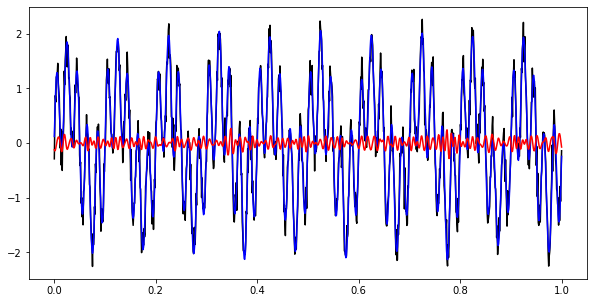

In [104]:
Fre = pywt.waverec((cA3, None, None, None), wvlt, mode='periodization')
Fre2 = pywt.waverec((None, cD3, None, None), wvlt, mode='periodization')

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, Fre, 'b') # это будет первая периодика
plt.plot(t, Fre2, 'r') # это будет вторая периодика
plt.show()

Видно, что при разложении до 3 уровня, мы получили более качественную апроксимацию исходного ряда, при этом мы не получили такие точные переодики, как при разложении до 4 уровня 

Декомпозируем ряд при помощи вейвлета Добеши (db8) до 5 уровня, несмотря на то, что максимальный уровень равен 6. Так мы получим большую точность декомпозиции для данного ВР:

In [105]:
my_wvlt = pywt.Wavelet('db8')
pywt.dwt_max_level(len(F), my_wvlt)

6

In [106]:
cA5, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(F, my_wvlt, mode='periodization', level=5)

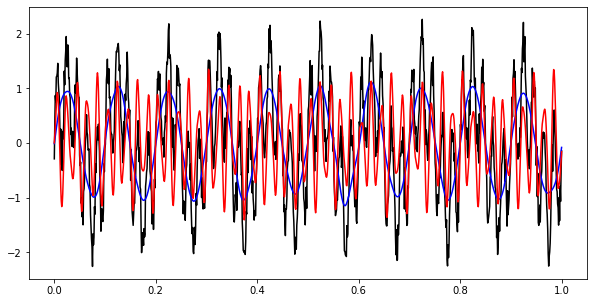

In [107]:
Fre = pywt.waverec((cA5, cD5, None, None, None, None), my_wvlt, mode='periodization')
Fre2 = pywt.waverec((None, cD5, cD4, None, None, None), my_wvlt, mode='periodization')

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, Fre, 'b')
plt.plot(t, Fre2, 'r')
plt.show()

Произведем Стационарное  Вейвлет  Преобразование (SWT). Этот  метод  дает  гораздо  большие  возможности декомпозиции по уровню и по комбинации аппроксимаций и деталей:

In [108]:
(cA5, cD5), (cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pywt.swt(F, wvlt, level=5)

Восстановим искомые периодические компоненты следующей комбинацией пар, при этом нам еще потребуется нормировка, так как часть коэффициентов мы полностью выбросили:

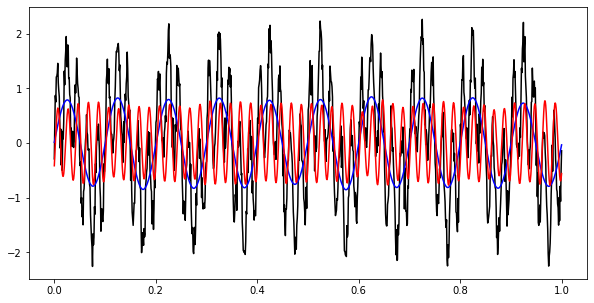

In [109]:
rr1 = pywt.iswt([(cA5, cD5)], wvlt)
rr2 = pywt.iswt([(cD4, cD3)], wvlt)

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, rr1/5, 'b') # перенормируем
plt.plot(t, rr2/4, 'r') # перенормируем
plt.show()

Теперь проведем декомпозицию SWT при помощи вейвлета Добеши (db8):

In [110]:
(cA6, cD6), (cA5, cD5), (cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pywt.swt(F, my_wvlt, level=6)

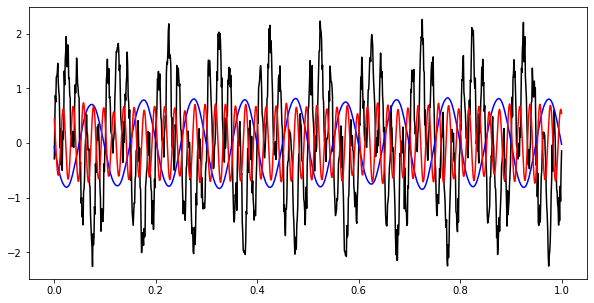

In [111]:
rr1 = pywt.iswt([(cA5, cD3)], my_wvlt)
rr2 = pywt.iswt([(cD4, cD3)], my_wvlt)

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, rr1/5, 'b') # перенормируем
plt.plot(t, rr2/4, 'r') # перенормируем
plt.show()

Проделаем пакетную вейвлет декомпозицию (WPD):

In [112]:
wp = pywt.WaveletPacket(data=F, wavelet='dmey', mode='periodization')
print([node.path for node in wp.get_level(4,  'freq')])  # выводим все комбинации узлов, упорядоченные по их частотной ширине спектра

['aaaa', 'aaad', 'aadd', 'aada', 'adda', 'addd', 'adad', 'adaa', 'ddaa', 'ddad', 'dddd', 'ddda', 'dada', 'dadd', 'daad', 'daaa']


Попробуем удалить один из узлов и посмотреть, что получится:

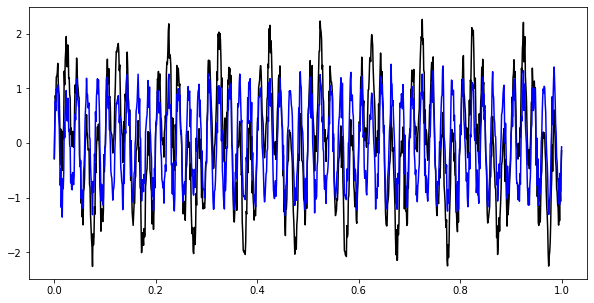

In [113]:
del wp['aaaa'] # удалим самый «глубокий» узел
reF= wp.reconstruct() # и восстановим ряд...

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, reF, 'b')# получим нечто периодическое, плохого качества
plt.show()

Если  удаление  узлов  не  приводит  к  желаемым  результатам, возможно есть смысл делать отдельную выборку ветвей этих узлов:

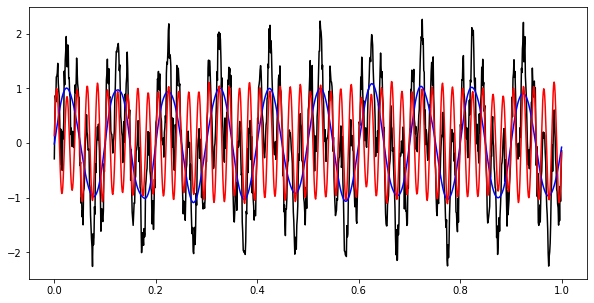

In [114]:
wp = pywt.WaveletPacket(data=F, wavelet='dmey', mode='periodization')

new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')
new_wp['aaaa'] = wp['aaaa'].data#  выбираем первую ветвь
new_wp.reconstruct(update=True)  # обновляем данные 
reF1 = new_wp.data # восстанавливаем под нее ряд 1

new_wp = pywt.WaveletPacket(data=None, wavelet='dmey', mode='periodization')
new_wp['aaad'] = wp['aaad'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные 
reF2 = new_wp.data # восстанавливаем под нее ряд 2

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, reF1, 'b') #компонента1
plt.plot(t, reF2, 'r')# компонента2
plt.show()

Теперь проведем декомпозицию Пакетной Вейвлет  Декомпозицией при помощи вейвлета Добеши (db8):

In [115]:
wp = pywt.WaveletPacket(data=F, wavelet='db8', mode='periodization')

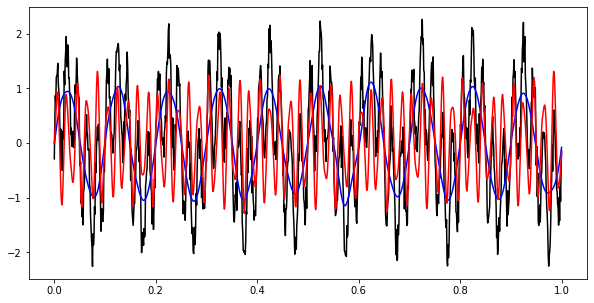

In [116]:
new_wp = pywt.WaveletPacket(data=None, wavelet='db8', mode='periodization')
new_wp['aaaa'] = wp['aaaa'].data#  выбираем первую ветвь
new_wp.reconstruct(update=True)  # обновляем данные 
reF1 = new_wp.data # восстанавливаем под нее ряд 1

new_wp = pywt.WaveletPacket(data=None, wavelet='db8', mode='periodization')
new_wp['aaad'] = wp['aaad'].data # выбираем вторую ветвь
new_wp.reconstruct(update=True) # обновляем данные 
reF2 = new_wp.data # восстанавливаем под нее ряд 2

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, reF1, 'b') #компонента1
plt.plot(t, reF2, 'r')# компонента2
plt.show()

Декомпозируем   сигнал   с   частотным изломом   на   2 периодические компоненты, разделенные по времени при помощи вейвлета Добеши:

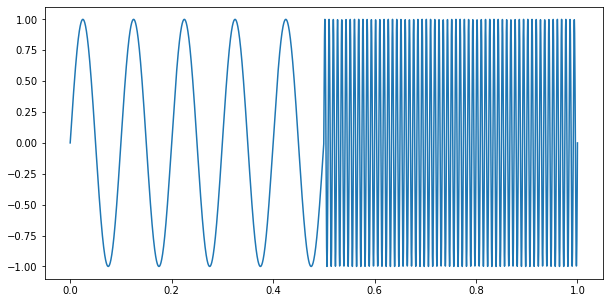

In [117]:
t = np.linspace(0, 1, 4096)
xf= np.zeros(4096)

for i in range(0, len(t)//2):
  xf[i] = np.sin(2*np.pi*10*t[i])

for i in range(len(t)//2, len(t)):
  xf[i] = np.sin(2*np.pi*120*t[i])
  
plt.figure(figsize = (10, 5))
plt.plot(t, xf)
plt.show()

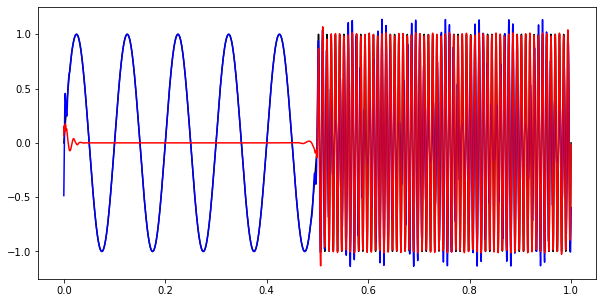

In [118]:
cA5, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(xf, my_wvlt, mode='periodization', level=5)

Fre = pywt.waverec((cA5, cD5, None, None, None, None), my_wvlt, mode='periodization')
Fre2 = pywt.waverec((None, cD5, cD4, None, None, None), my_wvlt, mode='periodization')

plt.figure(figsize = (10, 5))
plt.plot(t, xf, 'k')
plt.plot(t, Fre, 'b')
plt.plot(t, Fre2, 'r')
plt.show()

Далее выделим экспоненциальный тренд из зашумленного временного ряда:

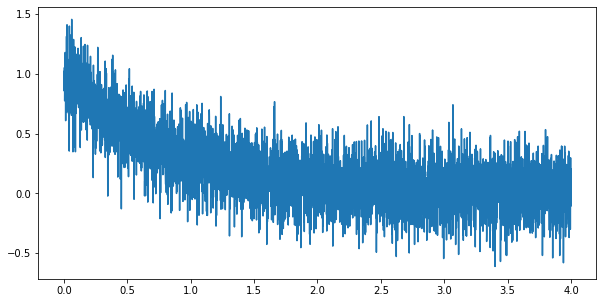

In [119]:
t = np.linspace(0,4,4110)
Fexp= np.exp(-0.4*np.pi*t) + 0.2*rand.randn(len(t))

plt.figure(figsize = (10, 5))
plt.plot(t, Fexp)
plt.show()

Возьмем самый глубокий уровень декомпозиции для данного вейвлета

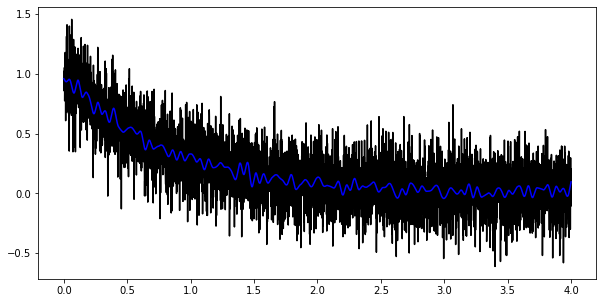

In [120]:
cA6, cD6, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(Fexp, my_wvlt, level=6)

Fre = pywt.waverec((cA6, cD6, None, None, None, None, None), my_wvlt)

plt.figure(figsize = (10, 5))
plt.plot(t, Fexp, 'k')
plt.plot(t, Fre, 'b')
plt.show()

Смоделируем временной рядиз 4  гармоник  с  шумом,  и разделим его на 4 гармоники с помощью вейвлет декомпозиции:

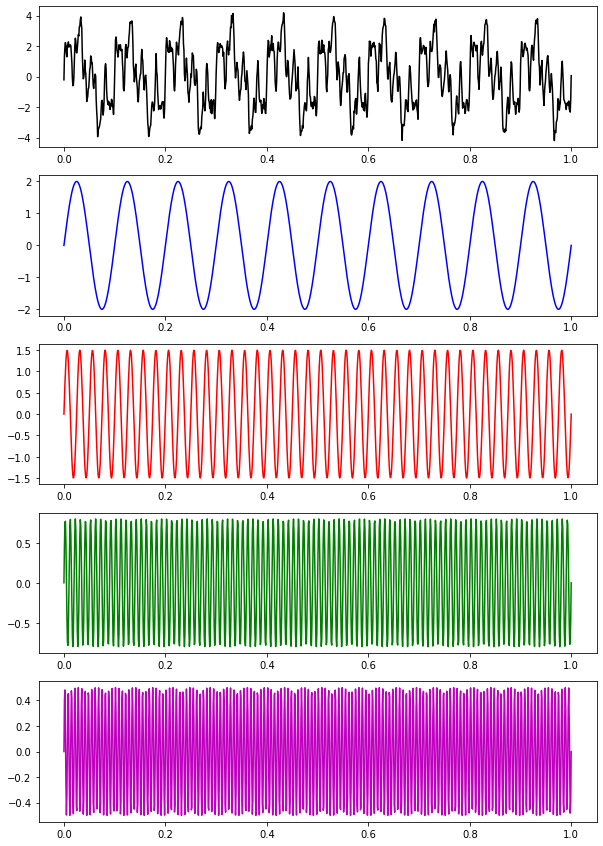

In [121]:
t = np.linspace(0,1,1024)
f1 = 10
f2 = 40
f3 = 100
f4 = 150
F = 2.0*np.sin(2*np.pi*f1*t)+1.5*np.sin(2*np.pi*f2*t)+0.8*np.sin(2*np.pi*f3*t)+0.5*np.sin(2*np.pi*f4*t)+0.2*rand.randn(len(t))

plt.figure(figsize = (10, 15))
plt.subplot(5,1,1)
plt.plot(t, F, 'k')
plt.subplot(5,1,2)
plt.plot(t, 2.0*np.sin(2*np.pi*f1*t), 'b')
plt.subplot(5,1,3)
plt.plot(t, 1.5*np.sin(2*np.pi*f2*t), 'r')

plt.subplot(5,1,4)
plt.plot(t, 0.8*np.sin(2*np.pi*f3*t), 'g')
plt.subplot(5,1,5)
plt.plot(t, 0.5*np.sin(2*np.pi*f4*t), 'm')
plt.show()

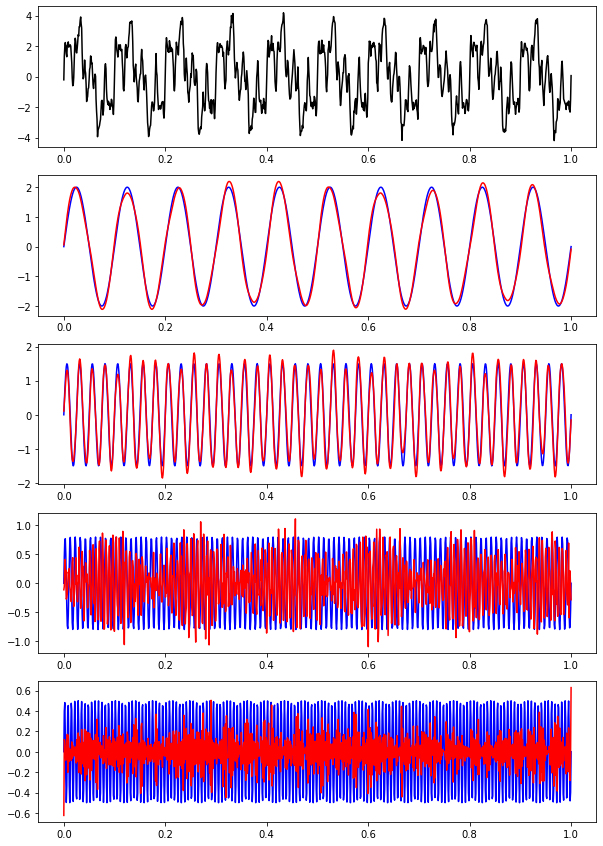

In [122]:
cA6, cD6, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(F, my_wvlt, mode='periodization', level=6)
Fre1 = pywt.waverec((cA6, cD6, None, None, None, None, None), my_wvlt, mode='periodization')
Fre2 = pywt.waverec((None, cD5, cD4, None, None, None), my_wvlt, mode='periodization')

Fre3 = pywt.waverec((None, cD2, cD1), wvlt, mode='periodization')
Fre4 = pywt.waverec((None, cD1), my_wvlt, mode='periodization')

plt.figure(figsize = (10, 15))
plt.subplot(5,1,1)
plt.plot(t, F, 'k')
plt.subplot(5,1,2)
plt.plot(t, 2.0*np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, Fre1, 'r')
plt.subplot(5,1,3)
plt.plot(t, 1.5*np.sin(2*np.pi*f2*t), 'b')
plt.plot(t, Fre2, 'r')
plt.subplot(5,1,4)
plt.plot(t, 0.8*np.sin(2*np.pi*f3*t), 'b')
plt.plot(t, Fre3, 'r')
plt.subplot(5,1,5)
plt.plot(t, 0.5*np.sin(2*np.pi*f4*t), 'b')
plt.plot(t, Fre4, 'r')
plt.show()